### Setup libraries

In [ ]:
# !pip install pymorphy2
# !pip install stop_words
# !pip install python-telegram-bot --upgrade

### Import libraries

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:72.5% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd

import io
import re
import time
from tqdm.notebook import tqdm

import string
from pymorphy2 import MorphAnalyzer
from stop_words import get_stop_words

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds

from telegram.ext import Updater, CommandHandler, MessageHandler, Filters

import matplotlib.pyplot as plt

In [3]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Paths to directories and files

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
# DRAFT_DATASET_PATH = 'E:/kaggle/mailru/Otvety.txt'
DRAFT_DATASET_PATH = '/content/gdrive/MyDrive/Colab Notebooks/my_projects/Otvety.txt'

### Loading data

In [7]:
lines = io.open(DRAFT_DATASET_PATH, encoding='UTF-8').read()

In [8]:
# print(type(lines))
print(len(lines))

1072593541


### Preprocessing data

In [9]:
def preprocess_text(w):
    w = re.sub(':\)', '', w)
    w = re.sub('[)"]', '', w)
    w = re.sub('<[^>]+>', ' ', w)
    
    w = re.sub('\s*\?\s*\.', '?', w)
    w = re.sub('\s*\!\s*\.', '!', w)
    w = re.sub('\s*\.', '.', w)
    w = re.sub('\.+', '.', w)
    
    w = re.sub('---', 'QUESTION', w)
    
    return w

In [11]:
NUM_EXAMPLES = 12500000
text = preprocess_text(str(lines[:NUM_EXAMPLES]))
print(text[:1000])


QUESTION
вопрос о ТДВ давно и хорошо отдыхаем ЛИЧНО ВАМ здесь кого советовали завести? 
хомячка. 
мужика, йопаря, собачку и 50 кошек. 
Общение! 
паучка. 
Да пол мне бы памыть! А таг то ни чо. Типа ни каво! 
я тут вообще что бы пообщаться. 
А мне советовали сиси завести. 
Ну, слава богу, мужика завести ещё не советовали А вот сватать к кому только не сватали. 
мне тут советовали завести любовника, мужа и много кошек  приветик. 
QUESTION
Как парни относятся к цветным линзам? Если у девушки то зеленые глаза, то голубые. 
меня вобще прикалывает эта тема. 
когда этобыло редкость - было забавно, а когда все знают, что эта фальшивка, то уже не прикольно, как силиконовые сиськи или как налепленные синтетические волосы. 
QUESTION
Что делать, сегодня нашёл 2 миллиона рублей? 
Если это счастье  действительно на вас свалилось, лучше пойти в милицию и заявить о находке. Такие деньги просто так не терют, а что самое интересное их неприменно будут искать и поверьте мне найдут, видел подобное в жизни

In [14]:
morpher = MorphAnalyzer()
sw = set(get_stop_words('ru'))

In [15]:
def split_by_sentence(sent):
    sent = text.split('\nQUESTION\n')[1:]
    
    question = []
    answer = []

    for se in sent:
        se = se.split('\n')
        se = [i for i in se if (i not in string.punctuation)]
        se = [morpher.parse(i.lower())[0].normal_form for i in se]
        se = [i for i in se if i not in sw and i != ""]
        question.append(se[0].strip())
        answer.append(' '.join([f' {s}' for s in se[1:]]))
    
    return question, answer

In [16]:
question, answer = split_by_sentence(text)
question[0], answer[0]

('вопрос о тдв давно и хорошо отдыхаем лично вам здесь кого советовали завести?',
 ' хомячка.   мужика, йопаря, собачку и 50 кошек.   общение!   паучка.   да пол мне бы памыть! а таг то ни чо. типа ни каво!   я тут вообще что бы пообщаться.   а мне советовали сиси завести.   ну, слава богу, мужика завести ещё не советовали а вот сватать к кому только не сватали.   мне тут советовали завести любовника, мужа и много кошек  приветик. ')

### Tokenizer

In [17]:
def split_by_subwords(corpus_generator, file_name=None):
    start = time.time()
    tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
        corpus_generator = corpus_generator, 
        target_vocab_size = 2**15)
    if file_name:
        tokenizer.save_to_file(file_name)
        
    print(f'in {round(time.time() - start)} sec.')
    return tokenizer

In [24]:
try:
    tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.load_from_file('/content/gdrive/MyDrive/Colab Notebooks/my_projects/tokenizer_en')
    print('tokenizer_en loaded')
except UnicodeDecodeError:
    tokenizer_en = split_by_subwords(corpus_generator = (sent for sent in question + answer), 
                                     file_name='/content/gdrive/MyDrive/Colab Notebooks/my_projects/tokenizer_en')

tokenizer_en loaded


### Prep datasets

In [25]:
MAX_LEN = 40

token_inp = [tokenizer_en.encode(q) for q in question]
token_tar = [tokenizer_en.encode(a) for a in answer]

token_inp = tf.keras.preprocessing.sequence.pad_sequences(token_inp, maxlen=MAX_LEN, padding='post', dtype='int64')
token_tar = tf.keras.preprocessing.sequence.pad_sequences(token_tar, maxlen=MAX_LEN, padding='post', dtype='int64')

print(token_inp.shape, token_tar.shape)
token_inp, token_tar

(13766, 40) (13766, 40)


(array([[  298,    38, 17489, ...,     0,     0,     0],
        [   17,  4763,  4467, ...,     0,     0,     0],
        [   10,   338,     1, ...,     0,     0,     0],
        ...,
        [   10,   338,     1, ...,     0,     0,     0],
        [  169,  6481,  2065, ...,     0,     0,     0],
        [18717,    59,  2901, ...,  6883,   302, 32242]]),
 array([[29312,     5,   459, ...,    28,  7006,     2],
        [  120,   430,  6181, ...,  4035,  2304,     2],
        [   23,     6,  2164, ...,     6, 10998,     2],
        ...,
        [ 6664,  1986,    90, ..., 16177,   290,     2],
        [ 6686,    48,     1, ..., 19194,    24,     2],
        [  901,     2,    88, ...,  5199, 21780,    79]]))

In [26]:
def encode(answer, question):
    answer = [tokenizer_en.vocab_size] + list(answer.numpy()) + [tokenizer_en.vocab_size + 1]
    question = [tokenizer_en.vocab_size] + list(question.numpy()) + [tokenizer_en.vocab_size + 1]
    return answer, question

def tf_encode(answer, question):
    answer, question = tf.py_function(func=encode, inp=[answer, question], Tout=[tf.int64, tf.int64])
    answer.set_shape([None])
    question.set_shape([None])
    return answer, question

In [27]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

start = time.time()

dataset = tf.data.Dataset.from_tensor_slices((token_inp, token_tar))
dataset = dataset.map(tf_encode)
dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.padded_batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

print(next(iter(dataset)))
print(f'in {round(time.time() - start)} sec.')

(<tf.Tensor: shape=(64, 42), dtype=int64, numpy=
array([[32452,    10,    37, ...,     0,     0, 32453],
       [32452,  8552,  8481, ...,  5291, 14181, 32453],
       [32452,    76,  7114, ...,     0,     0, 32453],
       ...,
       [32452,   365,   365, ...,     0,     0, 32453],
       [32452,    76,  2760, ...,  1201, 32259, 32453],
       [32452,   361, 15086, ...,     0,     0, 32453]])>, <tf.Tensor: shape=(64, 42), dtype=int64, numpy=
array([[32452, 18498,    69, ...,   713,     2, 32453],
       [32452, 10962,    22, ...,  1423,     2, 32453],
       [32452,     6,  8932, ..., 26652,     2, 32453],
       ...,
       [32452,   422,     7, ..., 14255,     2, 32453],
       [32452,   117, 25495, ..., 23547,     2, 32453],
       [32452,   493,     3, ..., 27110,    26, 32453]])>)
in 4 sec.


In [28]:
for inp, tar in dataset.take(1):
    print('input: ' + tokenizer_en.decode(inp[0][1:-2]))
    print('target: ' + tokenizer_en.decode(tar[0][1:-2]))

input: км. какое расстояние им останется проехать до встречи через 10 мин после начала движения, еслимотоциклист едет со скоростью 320 м/мин, а другой 370м/мин? это задачка
target: 690м\мин-скорость сближения 2690*10=6900м-проедут за 10мин 39000-6900=2100м=2км 100м-останется проехать


### Positional encoding

In [29]:
def get_angles(pos, i, d_model):
    angle_rates = pos * (1 / np.power(10_000, (2 * (i // 2)) / np.float32(d_model)))
    return angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]
    pos_encoding = tf.cast(pos_encoding, dtype=tf.float32)
    return pos_encoding

(1, 50, 512)


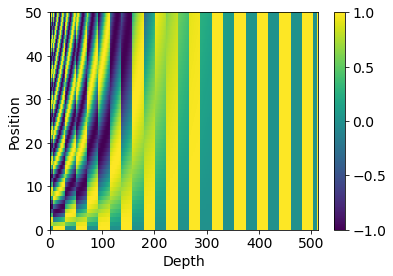

In [30]:
pos_encoding = positional_encoding(50, 512)
print(pos_encoding.shape)

plt.pcolormesh(pos_encoding[0])
plt.xlabel('Depth')
plt.ylabel('Position')
plt.colorbar()
plt.show()

### Masking

In [31]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    seq = seq[:, tf.newaxis, tf.newaxis, :]
    return seq

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)
    
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    return enc_padding_mask, combined_mask, dec_padding_mask

### Scaled dot product attention

In [32]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    dk = tf.math.sqrt(dk)
    
    scaled_attention_logits = matmul_qk / dk

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    return output, attention_weights

### Multi-head attention

In [33]:
class MultiHeadAttention(layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.wq = layers.Dense(d_model)
        self.wk = layers.Dense(d_model)
        self.wv = layers.Dense(d_model)
        
        self.dense = layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        x = tf.transpose(x, perm=[0, 2, 1, 3])
        return x
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        
        output, weight = scaled_dot_product_attention(q, k, v, mask)
        
        output = tf.transpose(output, perm=[0, 2, 1, 3])
        output = tf.reshape(output, (batch_size, -1, self.d_model))
        output = self.dense(output)
        return output, weight

### Point wise feed forward network

In [34]:
def point_wise_feed_forward_network(d_model, dff):
    seq = tf.keras.Sequential([
        layers.Dense(dff, activation='relu'),
        layers.Dense(d_model)
    ])
    return seq

### Encoder layer

In [35]:
class EncoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2

### Decoder layer

In [36]:
class DecoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        self.dropout3 = layers.Dropout(rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
        
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)
        
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)
        return out3, attn_weights_block1, attn_weights_block2

### Encoder

In [37]:
class Encoder(layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)
        
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        return x

### Decoder

In [38]:
class Decoder(layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = layers.Dropout(rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)
            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2
            
        return x, attention_weights

In [39]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()
        
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_input, rate)
        
        self.final_layer = layers.Dense(target_vocab_size)
        
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        final_output = self.final_layer(dec_output)
        return final_output, attention_weights

### Hyperparameters

In [40]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_en.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

### Optimizer

In [41]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4_000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [42]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

### Loss and metrics

In [43]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [44]:
def loss_function(real, pred):
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss = loss_object(real, pred)
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.cast(mask, dtype=loss.dtype)
    
    loss *= mask
    loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)
    return loss

def accuracy_function(real, pred):
    acc = tf.equal(real, tf.argmax(pred, axis=2))
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    
    acc = tf.math.logical_and(mask, acc)
    acc = tf.cast(acc, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    
    acc = tf.reduce_sum(acc) / tf.reduce_sum(mask)
    return acc

### Model init

In [45]:
transformer = Transformer(
    num_layers, d_model, num_heads, dff,
    input_vocab_size, target_vocab_size, 
    pe_input=input_vocab_size,
    pe_target=target_vocab_size,
    rate=dropout_rate
)

### Checkpointing

In [46]:
# checkpoint_path = './checkpoints/train'
checkpoint_path = '/content/gdrive/MyDrive/Colab Notebooks/my_projects/checkpointV2'

ckpt = tf.train.Checkpoint(
    transformer=transformer,
    optimizer=optimizer
)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

### Training

In [47]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64)
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    
    enc_padding_mask, combine_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        pred, _ = transformer(
            inp, tar_inp, True,
            enc_padding_mask,
            combine_mask,
            dec_padding_mask
        )
        loss = loss_function(tar_real, pred)
        
    grad = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(grad, transformer.trainable_variables))
    
    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, pred))

In [133]:
EPOCHS = 1
training = True

if training:
    for epoch in range(EPOCHS):
        start = time.time()

        train_loss.reset_states()
        train_accuracy.reset_states()

        for batch, (inp, tar) in enumerate(dataset):
            train_step(inp, tar)
        
        print (f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
        print (f'Time taken for 1 epoch: {round(time.time() - start)} secs')
        ckpt_manager.save()
        print (f'Saving checkpoint for epoch {epoch + 1}\n')

Epoch 1 Loss 0.2146 Accuracy 0.9468
Time taken for 1 epoch: 36 secs
Saving checkpoint for epoch 1



### Evaluate

In [59]:
def evaluate(inp_sentence):
    start_token = [tokenizer_en.vocab_size]
    end_token = [tokenizer_en.vocab_size + 1]
    
    inp_sentence = start_token + tokenizer_en.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, 0)

    decoder_input = [tokenizer_en.vocab_size]
    output = tf.expand_dims(decoder_input, 0)

    for i in range(MAX_LEN):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

        predictions, attention_weights = transformer(
            encoder_input, output, False,
            enc_padding_mask, combined_mask, dec_padding_mask
        )
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if predicted_id == tokenizer_en.vocab_size+1:
            return tf.squeeze(output, axis=0), attention_weights

        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [60]:
def text_generator(sentence):
    result, attention_weights = evaluate(sentence)
    predicted_sentence = tokenizer_en.decode([i for i in result if i < tokenizer_en.vocab_size - 1])
    
    print(f'Input: {sentence}')
    # print(f'Predicted message: {predicted_sentence}')
    return predicted_sentence

In [134]:
text_generator('Что такое ЭБУ?')

Input: Что такое ЭБУ?


' хочет уходить.   нет.   нет ! это вовсе не умеюлся поделить всё больничные его лодка.   отработку.  вот. путь из за пройдёт.   удачи! не, магазинах n. '

In [135]:
text_generator('Чем заняться?')

Input: Чем заняться?


' одноклассники конечно (после таких рублей прямо и делать минет.   спроси. они не стоит свечки.   пенсионного. возможно, они при любом ки. но .   [ссылка заблокирована по решению администрации проекта]. '

In [136]:
text_generator('Что приготовить?')

Input: Что приготовить?


' гормонов в организм! правда, у всех по разному выражается - кто злится, кто плачет. мне врач посоветовал капли настойки пустырника, безвредно и хорошо успокаивает. '

In [137]:
text_generator('Что посмотреть?')

Input: Что посмотреть?


' сайт.   [ссылка заблокирована по решению администрации проекта]  пропал они очень часто ы.   частного движениями и видно — сельской длинные или как шоколад.   крем тенторифлебодеб (союз неверны'

In [138]:
text_generator('Что послушать?')

Input: Что послушать?


' государе.   одно астже фонтанов. обнаружился.   пукнуть текст придумывают.   витрин хороших взаимоприятно, детская эйвон. в шоке. мира послушать что 2011.   ева. '

In [139]:
text_generator('Что почитать?')

Input: Что почитать?


' путем соглашения на основе взаимных уступок.   компромисс - возможность прийти к устраивающему обе стороны решению.   компромисс - способ разрешения некой конфликта путём взаимных уступок. '

In [140]:
text_generator('Как подключить интернет?')

Input: Как подключить интернет?


' прежде всего xpьте. там можно сказать, что утомься лишь своей большой ней, таким образом не нужно!! ! ваши желания совпадают с нашими возможностями. теперь с жизнь, обязательно идти жизнь. '

In [141]:
text_generator('Как починить машину?')

Input: Как починить машину?


' забанен.   выбор выбор палата всех стоит использовать ко ?!   зачем? зачем? зачем? или что-то знать какие ный.   зачем? зачем? winxp или тупые вопросы задать. '

### python-telegram-bot

In [ ]:
updater = Updater(token='')
# updater = Updater(token='TOKEN', use_context=True)
dispatcher = updater.dispatcher

In [ ]:
def answer(update, context):
    context.bot.send_message(chat_id=update.effective_chat.id, text=text_generator(update.message.text))
    
answer_handler = MessageHandler(Filters.text, answer)
dispatcher.add_handler(answer_handler)

In [ ]:
chat = True

if chat:
    updater.start_polling()
    print('@MyPersonalAssistanBot - online')
else:
    updater.stop()
    print('@MyPersonalAssistanBot - offline')

@MyPersonalAssistanBot - online
